<img align="center" style="max-width: 1000px" src="https://github.com/HSG-AIML-Teaching/ML2022-Lab/blob/main/lab_3/banner.png?raw=1">


<img align="right" style="max-width: 200px; height: auto" src="https://github.com/HSG-AIML-Teaching/ML2022-Lab/blob/main/lab_3/hsg_logo.png?raw=1">


##  Lab 03 - Convolutional Neural Networks (CNNs)

Machine Learning, University of St. Gallen, Spring Term 2022

The lab environment is based on Jupyter Notebooks (https://jupyter.org), which allow to perform a variety of statistical evaluations and data analyses.

In this lab, we will learn how to enhance vanilla Artificial Neural Networks (ANNs) using `PyTorch` to classify even more complex images. Therefore, we use a special type of deep neural network referred to **Convolutional Neural Networks (CNNs)**. CNNs encompass the ability to take advantage of the hierarchical pattern in data and assemble more complex patterns using smaller and simpler patterns. Therefore, CNNs are capable to learn a set of discriminative features 'pattern' and subsequently utilize the learned pattern to classify the content of an image.

We will again use the functionality of the `PyTorch` library to implement and train an CNN based neural network. The network will be trained on a set of tiny images to learn a model of the image content. Upon successful training, we will utilize the learned CNN model to classify so far unseen tiny images into distinct categories such as aeroplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. 

The figure below illustrates a high-level view on the machine learning process we aim to establish in this lab.

<img align="center" style="max-width: 900px" src="https://raw.githubusercontent.com/HSG-AIML-Teaching/IEMBA2022-Lab/main/lab_05/classification.png">

(Image of the CNN architecture created via http://alexlenail.me/)

As always, pls. don't hesitate to ask all your questions either during the lab, post them in our CANVAS (StudyNet) forum (https://learning.unisg.ch), or send us an email (using the course email).

## 1. Lab Objectives:

After today's lab, you should be able to:

> 1. Understand the basic concepts, intuitions and major building blocks of **Convolutional Neural Networks (CNNs)**.
> 2. Know how to **implement and to train a CNN** to learn a model of tiny image data.
> 3. Understand how to apply such a learned model to **classify images** images based on their content into distinct categories.
> 4. Know how to **interpret and visualize** the model's classification results.

## 2. Setup of the Jupyter Notebook Environment

Similar to the previous labs, we need to import a couple of Python libraries that allow for data analysis and data visualization. We will mostly use the `PyTorch`, `Numpy`, `Sklearn`, `Matplotlib`, `Seaborn` and a few utility libraries throughout this lab:

In [1]:
# import standard python libraries
import os, urllib, io
from datetime import datetime
import numpy as np

Import Python machine / deep learning libraries:

In [2]:
# import the PyTorch deep learning library
import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable

Import the sklearn classification metrics:

In [3]:
# import sklearn classification evaluation library
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

Import Python plotting libraries:

In [4]:
# import matplotlib, seaborn, and PIL data visualization libary
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

Enable notebook matplotlib inline plotting:

In [5]:
%matplotlib inline

Import Google's GDrive connector and mount your GDrive directories:

In [6]:
# import the Google Colab GDrive connector
from google.colab import drive

# mount GDrive inside the Colab notebook
drive.mount('/content/drive')

Mounted at /content/drive


Create a structure of Colab Notebook sub-directories inside of GDrive to store (1) the data as well as (2) the trained neural network models:

In [7]:
# create Colab Notebooks directory
notebook_directory = '/content/drive/MyDrive/Colab Notebooks'
if not os.path.exists(notebook_directory): os.makedirs(notebook_directory)

 # create data sub-directory inside the Colab Notebooks directory
data_directory = '/content/drive/MyDrive/Colab Notebooks/data_cifar10'
if not os.path.exists(data_directory): os.makedirs(data_directory)

 # create models sub-directory inside the Colab Notebooks directory
models_directory = '/content/drive/MyDrive/Colab Notebooks/models_cifar10'
if not os.path.exists(models_directory): os.makedirs(models_directory)

Set a random `seed` value to obtain reproducible results:

In [8]:
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU

Google Colab provides the use of free GPUs for running notebooks. However, if you just execute this notebook as is, it will use your device's CPU. To run the lab on a GPU, got to `Runtime` > `Change runtime type` and set the Runtime type to `GPU` in the drop-down. Running this lab on a CPU is fine, but you will find that GPU computing is faster. *CUDA* indicates that the lab is being run on GPU.

Enable GPU computing by setting the `device` flag and init a `CUDA` seed:

In [9]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# init deterministic GPU seed
torch.cuda.manual_seed(seed_value)

# log type of device enabled
print('[LOG] notebook with {} computation enabled'.format(str(device)))

[LOG] notebook with cuda computation enabled


Let's determine if we have access to a GPU provided by e.g. Google's COLab environment:

In [10]:
!nvidia-smi

Sun Mar 20 18:09:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    33W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 3. Dataset Download and Data Assessment

The **CIFAR-10 database** (**C**anadian **I**nstitute **F**or **A**dvanced **R**esearch) is a collection of images that are commonly used to train machine learning and computer vision algorithms. The database is widely used to conduct computer vision research using machine learning and deep learning methods:

<img align="center" style="max-width: 500px; height: 500px" src="https://raw.githubusercontent.com/HSG-AIML-Teaching/IEMBA2022-Lab/main/lab_05/cifar10.png">

(Source: https://www.kaggle.com/c/cifar-10)

Further details on the dataset can be obtained via: *Krizhevsky, A., 2009. "Learning Multiple Layers of Features from Tiny Images",  
( https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf )."*

The CIFAR-10 database contains **60,000 color images** (50,000 training images and 10,000 validation images). The size of each image is 32 by 32 pixels. The collection of images encompasses 10 different classes that represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. Let's define the distinct classs for further analytics:

In [11]:
cifar10_classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Thereby the dataset contains 6,000 images for each of the ten classes. The CIFAR-10 is a straightforward dataset that can be used to teach a computer how to recognize objects in images.

Let's download, transform and inspect the training images of the dataset. Therefore, we first will define the directory we aim to store the training data:

In [12]:
train_path = data_directory + '/train_cifar10'

Now, let's download the training data accordingly:

In [13]:
# define pytorch transformation into tensor format
transf = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# download and transform training images
cifar10_train_data = torchvision.datasets.CIFAR10(root=train_path, train=True, transform=transf, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/Colab Notebooks/data_cifar10/train_cifar10/cifar-10-python.tar.gz to /content/drive/MyDrive/Colab Notebooks/data_cifar10/train_cifar10


Verify the volume of training images downloaded:

In [14]:
# get the length of the training data
len(cifar10_train_data)

50000

Furthermore, let's investigate a couple of the training images:

In [16]:
# set (random) image id
image_id = 1800

# retrieve image exhibiting the image id
cifar10_train_data[image_id]

(tensor([[[ 0.0118, -0.0039,  0.0118,  ...,  0.0353,  0.0353,  0.0275],
          [ 0.0039,  0.0039,  0.0118,  ...,  0.0275,  0.0275,  0.0196],
          [ 0.0196,  0.0039,  0.0196,  ...,  0.0431,  0.0353,  0.0353],
          ...,
          [-0.2000, -0.2627, -0.4745,  ...,  0.0510,  0.0353,  0.0275],
          [-0.1529, -0.2471, -0.3725,  ...,  0.0431,  0.0275,  0.0196],
          [-0.1373, -0.3725, -0.4902,  ...,  0.0275,  0.0196,  0.0118]],
 
         [[ 0.1922,  0.1765,  0.1922,  ...,  0.2000,  0.2000,  0.1922],
          [ 0.1922,  0.1843,  0.1922,  ...,  0.1922,  0.1922,  0.1843],
          [ 0.2000,  0.1843,  0.2000,  ...,  0.2078,  0.2000,  0.2000],
          ...,
          [-0.1137, -0.1843, -0.4667,  ...,  0.2314,  0.2157,  0.2078],
          [-0.0667, -0.1451, -0.3569,  ...,  0.2235,  0.2078,  0.2000],
          [-0.0588, -0.2471, -0.4588,  ...,  0.2078,  0.2000,  0.1922]],
 
         [[ 0.5451,  0.5216,  0.5373,  ...,  0.5529,  0.5529,  0.5451],
          [ 0.5373,  0.5216,

Ok, that doesn't seem easily interpretable ;) Let's first seperate the image from its label information:

In [17]:
cifar10_train_image, cifar10_train_label = cifar10_train_data[image_id]

Great, now we are able to visually inspect our sample image: 

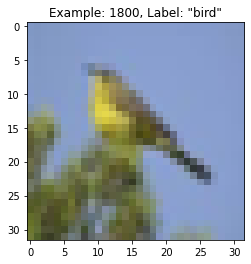

In [18]:
# define tensor to image transformation
trans = torchvision.transforms.ToPILImage()

# set image plot title 
plt.title('Example: {}, Label: "{}"'.format(str(image_id), str(cifar10_classes[cifar10_train_label])))

# un-normalize cifar 10 image sample
cifar10_train_image_plot = cifar10_train_image / 2.0 + 0.5

# plot 10 image sample
plt.imshow(trans(cifar10_train_image_plot))

Fantastic, right? Let's now decide on where we want to store the evaluation data:

In [19]:
eval_path = data_directory + '/eval_cifar10'

And download the evaluation data accordingly:

In [20]:
# define pytorch transformation into tensor format
transf = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# download and transform validation images
cifar10_eval_data = torchvision.datasets.CIFAR10(root=eval_path, train=False, transform=transf, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/Colab Notebooks/data_cifar10/eval_cifar10/cifar-10-python.tar.gz to /content/drive/MyDrive/Colab Notebooks/data_cifar10/eval_cifar10


Verify the volume of validation images downloaded:

In [ ]:
# get the length of the training data
len(cifar10_eval_data)

## 4. Neural Network Implementation

In this section we, will implement the architecture of the **neural network** we aim to utilize to learn a model that is capable of classifying the 32x32 pixel CIFAR 10 images according to the objects contained in each image. However, before we start the implementation, let's briefly revisit the process to be established. The following cartoon provides a birds-eye view:

<img align="center" style="max-width: 900px" src="https://raw.githubusercontent.com/HSG-AIML-Teaching/IEMBA2022-Lab/main/lab_05/process.png">

Our CNN, which we name 'CIFAR10Net' and aim to implement consists of two **convolutional layers** and three **fully-connected layers**. In general, convolutional layers are specifically designed to learn a set of **high-level features** ("patterns") in the processed images, e.g., tiny edges and shapes. The fully-connected layers utilize the learned features to learn **non-linear feature combinations** that allow for highly accurate classification of the image content into the different image classes of the CIFAR-10 dataset, such as, birds, aeroplanes, horses.

Let's implement the network architecture and subsequently have a more in-depth look into its architectural details:

In [ ]:
# implement the CIFAR10Net network architecture
class CIFAR10Net(nn.Module):
    
    # define the class constructor
    def __init__(self):
        
        # call super class constructor
        super(CIFAR10Net, self).__init__()
        
        # specify convolution layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        
        # define max-pooling layer 1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # specify convolution layer 2
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        
        # define max-pooling layer 2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # specify fc layer 1 - in 16 * 5 * 5, out 120
        self.linear1 = nn.Linear(16 * 5 * 5, 120, bias=True) # the linearity W*x+b
        self.relu1 = nn.ReLU(inplace=True) # the non-linearity
        
        # specify fc layer 2 - in 120, out 84
        self.linear2 = nn.Linear(120, 84, bias=True) # the linearity W*x+b
        self.relu2 = nn.ReLU(inplace=True) # the non-linarity
        
        # specify fc layer 3 - in 84, out 10
        self.linear3 = nn.Linear(84, 10) # the linearity W*x+b
        
        # add a softmax to the last layer
        self.logsoftmax = nn.LogSoftmax(dim=1) # the softmax
        
    # define network forward pass
    def forward(self, images):
        
        # high-level feature learning via convolutional layers
        
        # define conv layer 1 forward pass
        x = self.pool1(self.relu1(self.conv1(images)))
        
        # define conv layer 2 forward pass
        x = self.pool2(self.relu2(self.conv2(x)))
        
        # feature flattening
        
        # reshape image pixels
        x = x.view(-1, 16 * 5 * 5)
        
        # combination of feature learning via non-linear layers
        
        # define fc layer 1 forward pass
        x = self.relu1(self.linear1(x))
        
        # define fc layer 2 forward pass
        x = self.relu2(self.linear2(x))
        
        # define layer 3 forward pass
        x = self.logsoftmax(self.linear3(x))
        
        # return forward pass result
        return x

You may have noticed that we applied two more layers (compared to the MNIST example described in the last lab) before the fully-connected layers. These layers are referred to as **convolutional** layers and are usually comprised of three operations, (1) **convolution**, (2) **non-linearity**, and (3) **max-pooling**. Those operations are usually executed in sequential order during the forward pass through a convolutional layer.

In the following, we will have a detailed look into the functionality and number of parameters in each layer. We will start with providing images of 3x32x32 dimensions to the network, i.e., the three channels (red, green, blue) of an image each of size 32x32 pixels.

### 4.1. High-Level Feature Learning by Convolutional Layers

Let's first have a look into the convolutional layers of the network as illustrated in the following:

<img align="center" style="max-width: 600px" src="https://raw.githubusercontent.com/HSG-AIML-Teaching/IEMBA2022-Lab/main/lab_05/convolutions.png">

**First Convolutional Layer**: The first convolutional layer expects three input channels and will convolve six filters each of size 3x5x5. Let's briefly revisit how we can perform a convolutional operation on a given image. For that, we need to define a kernel which is a matrix of size 5x5, for example. To perform the convolution operation, we slide the kernel along with the image horizontally and vertically and obtain the dot product of the kernel and the pixel values of the image inside the kernel ('receptive field' of the kernel).

The following illustration shows an example of a discrete convolution:

<img align="center" style="max-width: 800px" src="https://raw.githubusercontent.com/HSG-AIML-Teaching/IEMBA2022-Lab/main/lab_05/convsample.png">

The left grid is called the input (an image or feature map). The middle grid, referred to as kernel, slides across the input feature map (or image). At each location, the product between each element of the kernel and the input element it overlaps is computed, and the results are summed up to obtain the output in the current location. In general, a discrete convolution is mathematically expressed by:

<center> $y(m, n) = x(m, n) * h(m, n) = \sum^{m}_{j=0} \sum^{n}_{i=0} x(i, j) * h(m-i, n-j)$, </center>

where $x$ denotes the input image or feature map, $h$ the applied kernel, and, $y$ the output.

When performing the convolution operation the 'stride' defines the number of pixels to pass at a time when sliding the kernel over the input. While 'padding' adds the number of pixels to the input image (or feature map) to ensure that the output has the same shape as the input. Let's have a look at another animated example:

<img align="center" style="max-width: 800px" src="https://raw.githubusercontent.com/HSG-AIML-Teaching/IEMBA2022-Lab/main/lab_05/convsample_animated.gif">

(Source: https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

In our implementation padding is set to 0 and stride is set to 1. As a result, the output size of the convolutional layer becomes 6x28x28, because (32 - 5) + 1 = 28. This layer exhibits ((5 x 5 x 3) + 1) x 6 = 456 parameter. 

**First Max-Pooling Layer:** The max-pooling process is a sample-based discretization operation. The objective is to down-sample an input representation (image, hidden-layer output matrix, etc.), reducing its dimensionality and allowing for assumptions to be made about features contained in the sub-regions binned.

To conduct such an operation, we again need to define a kernel. Max-pooling kernels are usually a tiny matrix of, e.g, of size 2x2. To perform the max-pooling operation, we slide the kernel along the image horizontally and vertically (similarly to a convolution) and compute the maximum pixel value of the image (or feature map) inside the kernel (the receptive field of the kernel).

The following illustration shows an example of a max-pooling operation:

<img align="center" style="max-width: 500px" src="https://raw.githubusercontent.com/HSG-AIML-Teaching/IEMBA2022-Lab/main/lab_05/poolsample.png">

The left grid is called the input (an image or feature map). The middle grid, referred to as kernel, slides across the input feature map (or image). We use a stride of 2, meaning the step distance for stepping over our input will be 2 pixels and won't overlap regions. At each location, the max value of the region that overlaps with the elements of the kernel and the input elements it overlaps is computed, and the results are obtained in the output of the current location.

In our implementation, we do max-pooling with a 2x2 kernel and stride 2 this effectively drops the original image size from 6x28x28 to 6x14x14.

**Second Convolutional Layer:** The second convolutional layer expects 6 input channels and will convolve 16 filters each of size 6x5x5x. Since padding is set to 0 and stride is set 1, the output size is 16x10x10, because (14  - 5) + 1 = 10. This layer therefore has ((5 x 5 x 6) + 1 x 16) = 24,16 parameter.

**Second Max-Pooling Layer:** The second down-sampling layer uses max-pooling with 2x2 kernel and stride set to 2. This effectively drops the size from 16x10x10 to 16x5x5. 

### 4.2. Flattening of Learned Features

The output of the final-max pooling layer needs to be flattened so that we can connect it to a fully connected layer. This is achieved using the `torch.Tensor.view` method. Setting the parameter of the method to `-1` will automatically infer the number of rows required to handle the mini-batch size of the data. 

### 4.3. Learning of Feature Classification

Let's now have a look into the non-linear layers of the network illustrated in the following:

<img align="center" style="max-width: 600px" src="https://raw.githubusercontent.com/HSG-AIML-Teaching/IEMBA2022-Lab/main/lab_05/fullyconnected.png">

The first fully connected layer uses 'Rectified Linear Units' (ReLU) activation functions to learn potential nonlinear combinations of features. The layers are implemented similarly to the fifth lab. Therefore, we will only focus on the number of parameters of each fully-connected layer:

**First Fully-Connected Layer:** The first fully-connected layer consists of 120 neurons, thus in total exhibits ((16 x 5 x 5) + 1) x 120 = 48,120 parameter. 

**Second Fully-Connected Layer:** The output of the first fully-connected layer is then transferred to second fully-connected layer. The layer consists of 84 neurons equipped with ReLu activation functions, this in total exhibits (120 + 1) x 84 = 10,164 parameter.

The output of the second fully-connected layer is then transferred to the output-layer (third fully-connected layer). The output layer is equipped with a softmax (that you learned about in the previous lab 05) and is made up of ten neurons, one for each object class contained in the CIFAR-10 dataset. This layer exhibits (84 + 1) x 10 = 850 parameter.


As a result our CIFAR-10 convolutional neural exhibits a total of 456 + 2,416 + 48,120 + 10,164 + 850 = 62,006 parameter.

(Source: https://www.stefanfiott.com/machine-learning/cifar-10-classifier-using-cnn-in-pytorch/)

Now, that we have implemented our first Convolutional Neural Network we are ready to instantiate a network model to be trained:

In [ ]:
model = CIFAR10Net()

Let's push the initialized `CIFAR10Net` model to the computing `device` that is enabled:

In [ ]:
model = model.to(device)

Let's double check if our model was deployed to the GPU if available:

In [ ]:
!nvidia-smi

Once the model is initialized we can visualize the model structure and review the implemented network architecture by execution of the following cell:

In [ ]:
# print the initialized architectures
print('[LOG] CIFAR10Net architecture:\n\n{}\n'.format(model))

Looks like intended? Brilliant! Finally, let's have a look into the number of model parameters that we aim to train in the next steps of the notebook:

In [ ]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in model.parameters():

    # collect number of parameters
    num_params += param.numel()
    
# print the number of model paramters
print('[LOG] Number of to be trained CIFAR10Net model parameters: {}.'.format(num_params))

Ok, our "simple" CIFAR10Net model already encompasses an impressive number 62'006 model parameters to be trained.

Now that we have implemented the CIFAR10Net, we are ready to train the network. However, before starting the training, we need to define an appropriate loss function. Remember, we aim to train our model to learn a set of model parameters $\theta$ that minimize the classification error of the true class $c^{i}$ of a given CIFAR-10 image $x^{i}$ and its predicted class $\hat{c}^{i} = f_\theta(x^{i})$ as faithfully as possible. 

In this lab we use (similarly to lab 05) the **'Negative Log-Likelihood (NLL)'** loss. During training the NLL loss will penalize models that result in a high classification error between the predicted class labels $\hat{c}^{i}$ and their respective true class label $c^{i}$. Now that we have implemented the CIFAR10Net, we are ready to train the network. Before starting the training, we need to define an appropriate loss function. Remember, we aim to train our model to learn a set of model parameters $\theta$ that minimize the classification error of the true class $c^{i}$ of a given CIFAR-10 image $x^{i}$ and its predicted class $\hat{c}^{i} = f_\theta(x^{i})$ as faithfully as possible. 

Let's instantiate the NLL via the execution of the following PyTorch command:

In [ ]:
# define the optimization criterion / loss function
nll_loss = nn.NLLLoss()

Let's also push the initialized `nll_loss` computation to the computing `device` that is enabled:

In [ ]:
nll_loss = nll_loss.to(device)

Based on the loss magnitude of a certain mini-batch PyTorch automatically computes the gradients. But even better, based on the gradient, the library also helps us in the optimization and update of the network parameters $\theta$.

We will use the **Stochastic Gradient Descent (SGD) optimization** and set the `learning-rate to 0.001`. Each mini-batch step the optimizer will update the model parameters $\theta$ values according to the degree of classification error (the NLL loss).

In [ ]:
# define learning rate and optimization strategy
learning_rate = 0.001
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)

Now that we have successfully implemented and defined the three CNN building blocks let's take some time to review the `CIFAR10Net` model definition as well as the `loss`. Please, read the above code and comments carefully and don't hesitate to let us know any questions you might have.

## 5. Neural Network Model Training

In this section, we will train our neural network model (as implemented in the section above) using the transformed images. More specifically, we will have a detailed look into the distinct training steps as well as how to monitor the training progress.

### 5.1. Preparing the Network Training

So far, we have pre-processed the dataset, implemented the CNN and defined the classification error. Let's now start to train a corresponding model for **20 epochs** and a **mini-batch size of 128** CIFAR-10 images per batch. This implies that the whole dataset will be fed to the CNN 20 times in chunks of 128 images yielding to **391 mini-batches** (50.000 training images / 128 images per mini-batch) per epoch. After the processing of each mini-batch, the parameters of the network will be updated. 

In [ ]:
# specify the training parameters
num_epochs = 20 # number of training epochs
mini_batch_size = 128 # size of the mini-batches

Furthermore, lets specifiy and instantiate a corresponding PyTorch data loader that feeds the image tensors to our neural network:

In [ ]:
cifar10_train_dataloader = torch.utils.data.DataLoader(cifar10_train_data, batch_size=mini_batch_size, shuffle=True)

### 5.2. Running the Network Training

Finally, we start training the model. The training procedure for each mini-batch is performed as follows: 

>1. do a forward pass through the CIFAR10Net network, 
>2. compute the negative log-likelihood classification error $\mathcal{L}^{NLL}_{\theta}(c^{i};\hat{c}^{i})$, 
>3. do a backward pass through the CIFAR10Net network, and 
>4. update the parameters of the network $f_\theta(\cdot)$.

To ensure learning while training our CNN model, we will monitor whether the loss decreases with progressing training. Therefore, we obtain and evaluate the classification performance of the entire training dataset after each training epoch. Based on this evaluation, we can conclude on the training progress and whether the loss is converging (indicating that the model might not improve any further).

The following elements of the network training code below should be given particular attention:
 
>- `loss.backward()` computes the gradients based on the magnitude of the reconstruction loss,
>- `optimizer.step()` updates the network parameters based on the gradient.

In [ ]:
# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode
model.train()

# train the CIFAR10 model
for epoch in range(num_epochs):
    
    # init collection of mini-batch losses
    train_mini_batch_losses = []
    
    # iterate over all-mini batches
    for i, (images, labels) in enumerate(cifar10_train_dataloader):
        
        # push mini-batch data to computation device
        images = images.to(device)
        labels = labels.to(device)

        # run forward pass through the network
        output = model(images)
        
        # reset graph gradients
        model.zero_grad()
        
        # determine classification loss
        loss = nll_loss(output, labels)
        
        # run backward pass
        loss.backward()
        
        # update network paramaters
        optimizer.step()
        
        # collect mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())

    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)
    
    # print epoch loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch), str(train_epoch_loss)))
    
    # set filename of actual model
    model_name = 'cifar10_model_epoch_{}.pth'.format(str(epoch))

    # save current model to GDrive models directory
    torch.save(model.state_dict(), os.path.join(models_directory, model_name))
    
    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)

Upon successfull training let's visualize and inspect the training loss per epoch:

In [ ]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Classification Error $L^{NLL}$', fontsize=10);

Ok, fantastic. The training error converges nicely. We could definitely train the network a couple more epochs until the error converges. But let's stay with the 20 training epochs for now and continue with evaluating our trained model.

## 6. Neural Network Model Evaluation

Prior to evaluating our model, let's load the best performing model. Remember, that we stored a snapshot of the model after each training epoch to our local model directory. We will now load the last snapshot saved.

In [ ]:
# restore pre-trained model snapshot
best_model_name = os.path.join(models_directory, 'cifar10_model_epoch_19.pth')

# load state_dict from path
state_dict_best = torch.load(best_model_name, map_location=torch.device('cpu'))

# init pre-trained model class
best_model = CIFAR10Net()

# load pre-trained models
best_model.load_state_dict(state_dict_best)

Let's inspect if the model was loaded successfully: 

In [ ]:
# set model in evaluation mode
best_model.eval()

In order to evaluate our trained model, we need to feed the CIFAR10 images reserved for evaluation (the images that we didn't use as part of the training process) through the model. Therefore, let's again define a corresponding PyTorch data loader that feeds the image tensors to our neural network: 

In [ ]:
cifar10_eval_dataloader = torch.utils.data.DataLoader(cifar10_eval_data, batch_size=10000, shuffle=False)

We will now evaluate the trained model using the same mini-batch approach as we did when training the network and derive the mean negative log-likelihood loss of all mini-batches processed in an epoch:

In [ ]:
# init collection of mini-batch losses
eval_mini_batch_losses = []

# iterate over all-mini batches
for i, (images, labels) in enumerate(cifar10_eval_dataloader):

    # run forward pass through the network
    output = best_model(images)

    # determine classification loss
    loss = nll_loss(output, labels)

    # collect mini-batch reconstruction loss
    eval_mini_batch_losses.append(loss.data.item())

# determine mean min-batch loss of epoch
eval_loss = np.mean(eval_mini_batch_losses)

# print epoch loss
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] eval-loss: {}'.format(str(now), str(eval_loss)))

Ok, great. The evaluation loss looks in-line with our training loss. Let's now inspect a few sample predictions to get an impression of the model quality. Therefore, we will again pick a random image of our evaluation dataset and retrieve its PyTorch tensor as well as the corresponding label:

In [ ]:
# set (random) image id
image_id = 777

# retrieve image exhibiting the image id
cifar10_eval_image, cifar10_eval_label = cifar10_eval_data[image_id]

Let's now inspect the true class of the image we selected:

In [ ]:
cifar10_classes[cifar10_eval_label]

Ok, the randomly selected image should contain a two (2). Let's inspect the image accordingly:

In [ ]:
# define tensor to image transformation
trans = torchvision.transforms.ToPILImage()

# set image plot title 
plt.title('Example: {}, Label: {}'.format(str(image_id), str(cifar10_classes[cifar10_eval_label])))

# un-normalize cifar 10 image sample
cifar10_eval_image_plot = cifar10_eval_image / 2.0 + 0.5

# plot cifar 10 image sample
plt.imshow(trans(cifar10_eval_image_plot))

Ok, let's compare the true label with the prediction of our model:

In [ ]:
cifar10_eval_image.unsqueeze(0).shape
best_model(cifar10_eval_image.unsqueeze(0))

We can even determine the likelihood of the most probable class:

In [ ]:
cifar10_classes[torch.argmax(best_model(Variable(cifar10_eval_image.unsqueeze(0))), dim=1).item()]

Let's now obtain the predictions for all the CIFAR-10 images of the evaluation data:

In [ ]:
predictions = torch.argmax(best_model(iter(cifar10_eval_dataloader).next()[0]), dim=1)

Furthermore, let's obtain the overall classification accuracy:

In [ ]:
metrics.accuracy_score(cifar10_eval_data.targets, predictions.detach())

Let's also inspect the confusion matrix of the model predictions to determine major sources of misclassification:

In [ ]:
# determine classification matrix of the predicted and target classes
mat = confusion_matrix(cifar10_eval_data.targets, predictions.detach())

# initialize the plot and define size
plt.figure(figsize=(8, 8))

# plot corresponding confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=cifar10_classes, yticklabels=cifar10_classes)
plt.tick_params(axis='both', which='major', labelsize=8, labelbottom = False, bottom=False, top = False, left = False, labeltop=True)

# set plot title
plt.title('CIFAR-10 classification matrix')

# set plot axis lables
plt.xlabel('[true label]')
plt.ylabel('[predicted label]');

Ok, we can easily see that our current model confuses images of cats and dogs as well as images of trucks and cars quite often. This is again not surprising since those image categories exhibit a high semantic and therefore visual similarity.

## 7. Lab Summary:

In this lab, a step by step introduction into **design, implementation, training and evaluation** of convolutional neural networks CNNs to classify tiny images of objects is presented. The code and exercises presented in this lab may serves as a starting point for developing more complex, deeper and more tailored CNNs.